In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde

In [3]:
sns.set(style="whitegrid")

interactions_file = "miRDB_v6.0_prediction_result.txt"
df = pd.read_csv(interactions_file, sep="\t")

print(f"Available columns: {df.columns}")

Available columns: Index(['miRNA', 'Gene ID', 'Target Score'], dtype='object')


In [5]:
# Filter only human miRNAs (miRNAs starting with "hsa-")
df = df[df['miRNA'].str.startswith("hsa")]

print("Filtered Human miRNAs dataset sample:")
print(df.head())

Filtered Human miRNAs dataset sample:
                   miRNA       Gene ID  Target Score
1776177  hsa-let-7a-2-3p  NM_001193338     67.202300
1776178  hsa-let-7a-2-3p  NM_001130845     89.899500
1776179  hsa-let-7a-2-3p     NM_170771     67.709800
1776180  hsa-let-7a-2-3p     NM_182607     52.130377
1776181  hsa-let-7a-2-3p     NM_014423     80.149571


In [9]:
df.to_csv("MirTarget all human interactions.txt", sep="\t", index=False)

In [7]:
x_common = np.linspace(df["Target Score"].min(), df["Target Score"].max(), 200)

In [9]:
mirna_kde_data = {}

for mirna, group in df.groupby('miRNA'):
    scores = group['Target Score'].dropna()

    if len(scores) >= 2 and scores.nunique() > 1:
        try:
            kde = gaussian_kde(scores)
            kde_vals = kde(x_common)

            if np.all(np.isfinite(kde_vals)):
                mirna_kde_data[mirna] = kde_vals
            else:
                print(f" KDE returned non-finite values for {mirna}")

        except Exception as e:
            print(f" KDE failed for {mirna}: {e}")

print(f" KDE successfully computed for {len(mirna_kde_data)} miRNAs")

kde_df = pd.DataFrame(mirna_kde_data, index=x_common)

mean_kde = kde_df.mean(axis=1)
std_kde = kde_df.std(axis=1)

print("Mean KDE shape:", mean_kde.shape)
print("STD KDE shape:", std_kde.shape)
print("First 10 Mean KDE values:", mean_kde.iloc[:10])
print("First 10 STD KDE values:", std_kde.iloc[:10])

 KDE successfully computed for 2656 miRNAs
Mean KDE shape: (200,)
STD KDE shape: (200,)
First 10 Mean KDE values: 50.000000    0.020549
50.251256    0.021656
50.502513    0.022736
50.753769    0.023780
51.005025    0.024782
51.256281    0.025735
51.507538    0.026633
51.758794    0.027473
52.010050    0.028250
52.261307    0.028962
dtype: float64
First 10 STD KDE values: 50.000000    0.005193
50.251256    0.005364
50.502513    0.005532
50.753769    0.005696
51.005025    0.005853
51.256281    0.006003
51.507538    0.006143
51.758794    0.006272
52.010050    0.006389
52.261307    0.006492
dtype: float64


In [11]:
# Avoid plotting failure (KDE should not be zero)
std_kde = np.maximum(std_kde, 1e-4)

Save as PNG? (yes/no):  yes


Saved as 'miRDB_Human_KDE_STD.png'.


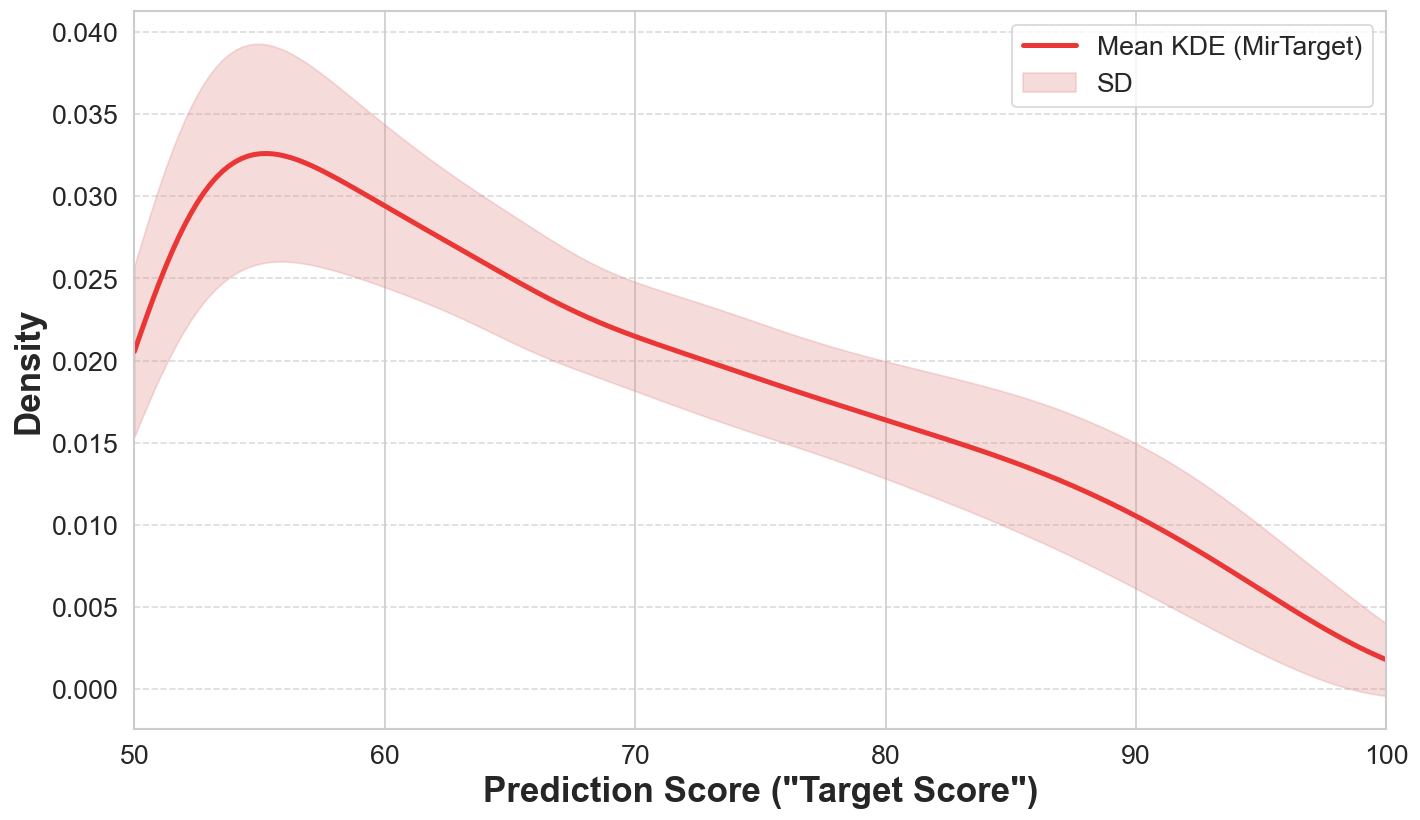

In [15]:
plt.figure(figsize=(12, 7), dpi=120)

plt.plot(x_common, mean_kde, color='#eb3636', linewidth=3, label="Mean KDE (MirTarget)")
plt.fill_between(x_common, mean_kde - std_kde, mean_kde + std_kde, color='#e38a8a', alpha=0.3, label="SD")


plt.xlabel('Prediction Score ("Target Score")', fontsize=21, fontweight="bold")
plt.ylabel('Density', fontsize=21, fontweight="bold")
plt.xlim(df["Target Score"].min(), df["Target Score"].max())
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(fontsize=16, loc='upper right')
plt.tick_params(axis='both', labelsize=16)
plt.tight_layout()

save_plot = input("Save as PNG? (yes/no): ").strip().lower()
if save_plot == 'yes':
    plt.savefig("miRDB_Human_KDE_STD.png", format='png', dpi=300, bbox_inches='tight')
    print("Saved as 'miRDB_Human_KDE_STD.png'.")

plt.show()